# Answer occurence analysis

The aim of this notebooks is to  investigate how good the actual answer marking are 

In [3]:
import pandas as pd
import re
import copy
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [4]:
import json
# Open the json file and load the data
def load_json(file):
    with open(file) as f:
        data = json.load(f)
    return data

def dump_json(file, data):
    with open(file, 'w') as f:
        json.dump(data, f)

**No fuzzy matching count**

This is the exact phrase used as answer without removing or preprocessing anything. How many answers has not been marked

In [5]:
data_viz_dict = {}
data = load_json('../data/train_separate_questions_full.json')
answers_marked = 0
answers_found = 0
answers_found_fuzzy = 0
pattern = r'[^A-Za-z0-9]+'
for contract in data['data']:
    for paragraph in contract['paragraphs']:
        context = paragraph['context']
        context_clean = re.sub(pattern, '', context)
        for qa in paragraph['qas']:
            if qa['question'] not in data_viz_dict:
                data_viz_dict[qa['question']] = [0,0,0]
            if qa['is_impossible']:
                continue
            for ans in qa['answers']:
                answers_marked += 1
                answer = ans['text']
                answer_clean = re.sub(pattern, '', answer)
                answers_found += context.count(answer)
                answers_found_fuzzy += context_clean.count(answer_clean)
                data_viz_dict[qa['question']][0] += context.count(answer)
                data_viz_dict[qa['question']][1] += 1
                data_viz_dict[qa['question']][2] += context_clean.count(answer_clean)

In [6]:
print(f"Answers marked by authors: {answers_marked} and found strinct: {answers_found} and fuzzy: {answers_found_fuzzy}")

Answers marked by authors: 6519 and found strinct: 61450 and fuzzy: 365270


There is definitely something here. Looks like the marking ar not very good and that we should look into where and why this it. This makes sense if it's confusing the models. Let's see if it's a specific category this happens to.

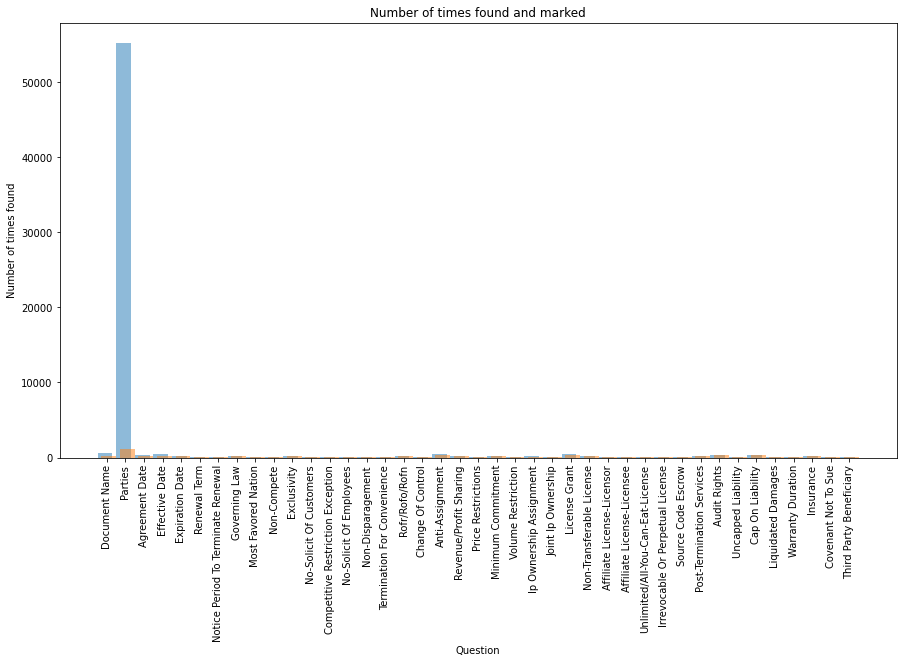

In [7]:
# Create bar chart for each question
X = data_viz_dict.keys()
X_short = [x.split('"')[1] for x in list(X)]
Y_Found = [data_viz_dict[x][0] for x in X]
Y_Marked = [data_viz_dict[x][1] for x in X]

fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(8)
fig.set_figwidth(15)
ind = np.arange(len(X_short))  # the x locations for the groups
width = 0.2      # the width of the bars

ax.bar(ind, Y_Found, align='center', alpha=0.5)
ax.bar(ind + width, Y_Marked, align='center', alpha=0.5)
ax.set_ylabel('Number of times found')
ax.set_xlabel('Question')
ax.set_xticks(ind + width / 2, rotation=90)
ax.set_xticklabels( X_short, rotation=90)
plt.title('Number of times found and marked')
plt.show()

Looks like it's primary the parties that is the issue. Let's drop it and look at the results

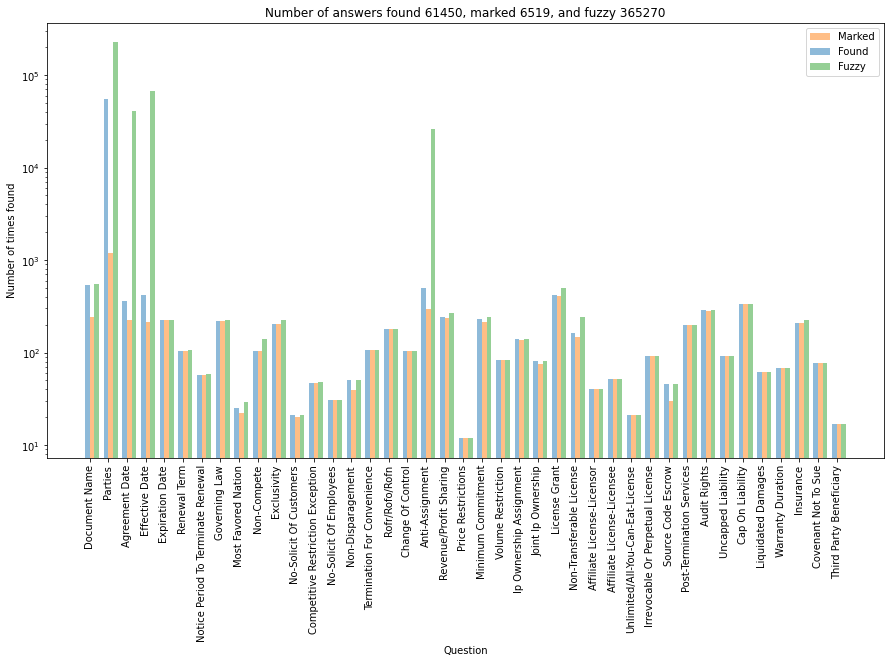

In [8]:
# Total answers marked and found
answers_marked = sum([x[1] for x in list(data_viz_dict.values())])
answers_found = sum([x[0] for x in list(data_viz_dict.values())])
answers_found_fuzzy = sum([x[2] for x in list(data_viz_dict.values())])


X = data_viz_dict.keys()
X_short = [x.split('"')[1] for x in list(X)]
Y_Found = [data_viz_dict[x][0] for x in X]
Y_Marked = [data_viz_dict[x][1] for x in X]
Y_Fuzzy = [data_viz_dict[x][2] for x in X]

fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(8)
fig.set_figwidth(15)
ind = np.arange(len(X_short))  # the x locations for the groups
width = 0.25      # the width of the bars

bar_found =ax.bar(ind, Y_Found, align='center', alpha=0.5, width=width)
bar_marked = ax.bar(ind + width , Y_Marked, align='center', alpha=0.5, width=width)
bar_fuzzy = ax.bar(ind + width*2, Y_Fuzzy, align='center', alpha=0.5, width=width)
ax.set_ylabel('Number of times found')
ax.set_xlabel('Question')
ax.set_xticks(ind + width / 2, rotation=90)
ax.set_xticklabels( X_short, rotation=90)
plt.yscale("log")  
plt.title(f'Number of answers found {answers_found}, marked {answers_marked}, and fuzzy {answers_found_fuzzy}')
plt.legend( (bar_marked, bar_found, bar_fuzzy), ('Marked','Found', 'Fuzzy') )
plt.savefig('Figures_For_Report/answer_occurence_analysis_Answers_Marked.png')
plt.show()

In [22]:
_data=[]
for idx, ele in enumerate(X_short):
    _data.append({'Question': ele, 'Count': Y_Found[idx], 'Type': 'found'})
    _data.append({'Question': ele, 'Count': Y_Marked[idx], 'Type': 'marked'})
    _data.append({'Question': ele, 'Count': Y_Fuzzy[idx], 'Type': 'fuzzy'})

df = pd.DataFrame(_data)


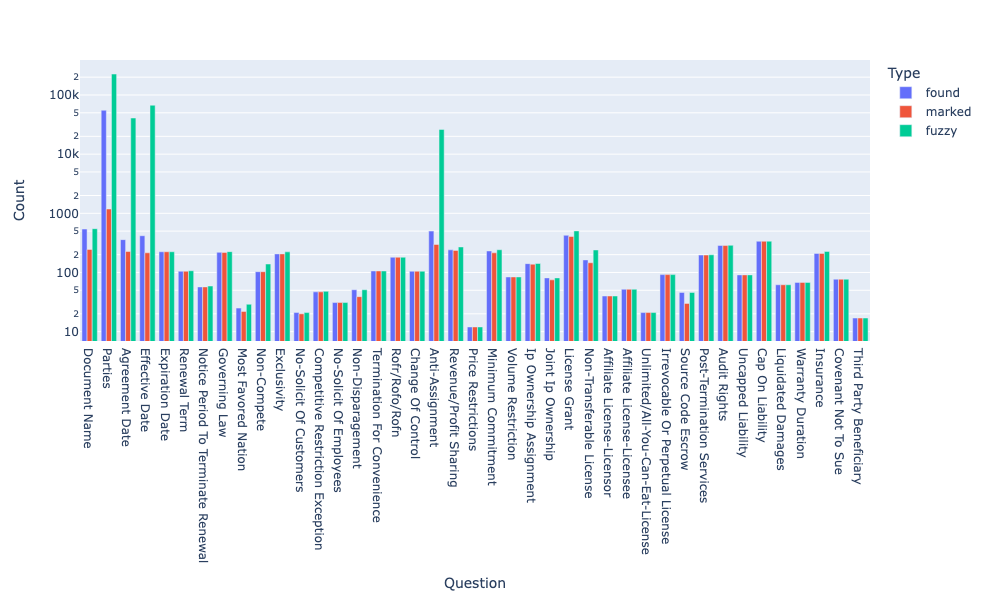

In [25]:
fig = px.bar(df, x="Question", y="Count", color="Type", barmode="group",log_y=True, width=1000, height=600)
fig.write_image("Figures_For_Report/answer_occurence_analysis_Answers_Marked_plotly.png")
fig.show()

Removing the most imbalanced categories

In [146]:
sorted_questions = sorted(list(data_viz_dict.keys()))
# identify id of questions
for idx, ele in enumerate(sorted_questions):
    # print(idx, ele)
    continue
ids_to_del = [2,3,9,10,12, 28]
for idx in ids_to_del:
    print("Deleting", sorted_questions[idx])
    del data_viz_dict[sorted_questions[idx]]

Deleting Highlight the parts (if any) of this contract related to "Agreement Date" that should be reviewed by a lawyer. Details: The date of the contract
Deleting Highlight the parts (if any) of this contract related to "Anti-Assignment" that should be reviewed by a lawyer. Details: Is consent or notice required of a party if the contract is assigned to a third party?
Deleting Highlight the parts (if any) of this contract related to "Document Name" that should be reviewed by a lawyer. Details: The name of the contract
Deleting Highlight the parts (if any) of this contract related to "Effective Date" that should be reviewed by a lawyer. Details: The date when the contract is effective 
Deleting Highlight the parts (if any) of this contract related to "Expiration Date" that should be reviewed by a lawyer. Details: On what date will the contract's initial term expire?
Deleting Highlight the parts (if any) of this contract related to "Parties" that should be reviewed by a lawyer. Details: 

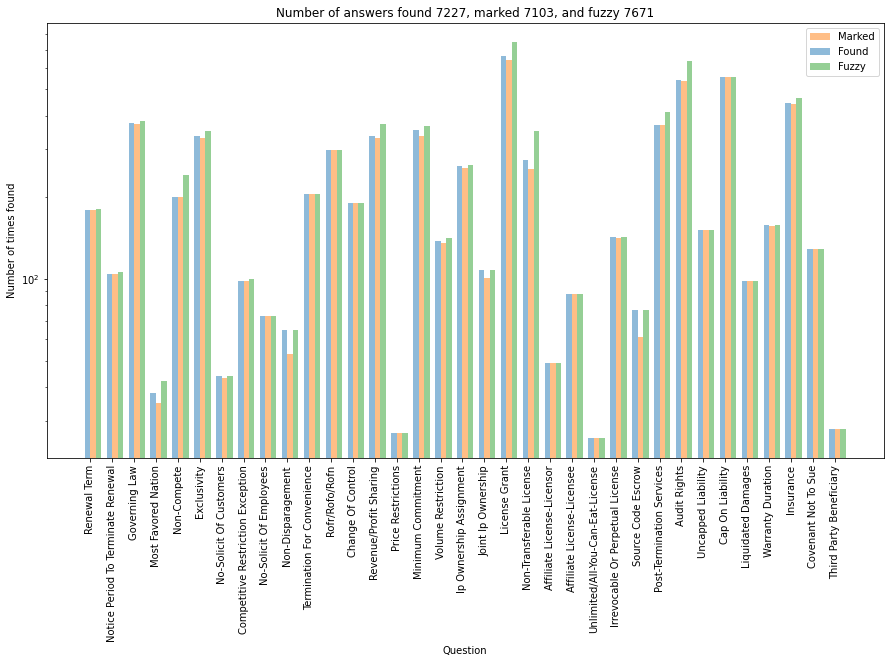

In [144]:
answers_marked = sum([x[1] for x in list(data_viz_dict.values())])
answers_found = sum([x[0] for x in list(data_viz_dict.values())])
answers_found_fuzzy = sum([x[2] for x in list(data_viz_dict.values())])


X = data_viz_dict.keys()
X_short = [x.split('"')[1] for x in list(X)]
Y_Found = [data_viz_dict[x][0] for x in X]
Y_Marked = [data_viz_dict[x][1] for x in X]
Y_Fuzzy = [data_viz_dict[x][2] for x in X]

fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(8)
fig.set_figwidth(15)
ind = np.arange(len(X_short))  # the x locations for the groups
width = 0.25      # the width of the bars

bar_found =ax.bar(ind, Y_Found, align='center', alpha=0.5, width=width)
bar_marked = ax.bar(ind + width , Y_Marked, align='center', alpha=0.5, width=width)
bar_fuzzy = ax.bar(ind + width*2, Y_Fuzzy, align='center', alpha=0.5, width=width)
ax.set_ylabel('Number of times found')
ax.set_xlabel('Question')
ax.set_xticks(ind + width / 2, rotation=90)
ax.set_xticklabels( X_short, rotation=90)
plt.yscale("log")  
plt.title(f'Number of answers found {answers_found}, marked {answers_marked}, and fuzzy {answers_found_fuzzy}')
plt.legend( (bar_marked, bar_found, bar_fuzzy), ('Marked','Found', 'Fuzzy') )
plt.savefig('Figures_For_Report/answer_occurence_analysis_Answers_Marked.png')
plt.show()

Lets look at some examples. Are they truly unmarked answers to the questions. We will take the contract "XinhuaSportsEntertainmentLtd" and look at the parties

In [157]:
# get example
data_test = load_json('../data/test_full.json')
for x in data_test['data']:
    if 'XinhuaSportsEntertainmentLtd' in x['title']:
        break

In [185]:
context = x['paragraphs'][0]['context']
qas = x['paragraphs'][0]['qas'][1]
print(qas['question'])
for x in qas['answers']:
    print(x['text'], x['answer_start'])


Highlight the parts (if any) of this contract related to "Parties" that should be reviewed by a lawyer. Details: The two or more parties who signed the contract
XFN 3046
CHINA ECONOMIC INFORMATION SERVICE OF XINHUA NEWS AGENCY 80
CEIS 2850
XINHUA FINANCIAL NETWORK LIMITED 206


In [189]:
[m.start() for m in re.finditer('CHINA ECONOMIC INFORMATION', context)]

[80, 2529, 18226]

In [194]:
loc=80
span=200
context[max(loc-span,0):loc+span]

'EXHIBIT 99.4\n\n                            DATED 15TH DECEMBER 2001\n\n            CHINA ECONOMIC INFORMATION SERVICE OF XINHUA NEWS AGENCY\n\n                                       AND\n\n                        XINHUA FINANCIAL NETWORK LIMITED\n\n                                   -----'

In [192]:
loc=2529
span=200
context[loc-span:loc+span]

'........................................................     8\n\nSchedule 1 - Contents\n\n                                       -i-\n\nTHIS AGREEMENT is made the 15th day of December 2001.\n\nBETWEEN\n\n(1)  CHINA ECONOMIC INFORMATION SERVICE OF XINHUA NEWS AGENCY, the organisation      within the Xinhua News Agency that is responsible for news and information      operations and business, registered in t'

This should definitely have been marked ...

## Answer distribution across question categories in train seperate

In [1]:
import json
# load json file
with open('../data/train_separate_questions_full.json') as json_file:
    data = json.load(json_file)

In [25]:
qa['question'].split('"')[1].split('"')[0]

'Third Party Beneficiary'

In [26]:
_data = []
q_idx_dict = {}
for contract in data['data']:
    for paragraph in contract['paragraphs']:
        for qa in paragraph['qas']:
            if qa['question'].split('"')[1].split('"')[0] not in q_idx_dict:
                q_idx_dict[qa['question'].split('"')[1].split('"')[0]] = 1
            else:
                q_idx_dict[qa['question'].split('"')[1].split('"')[0]] += 1
            

In [32]:
len(data['data'])

408

In [41]:
import pandas as pd
df = pd.DataFrame(list(q_idx_dict.items()), columns=['question', 'count']).sort_values(by='count', ascending=False)

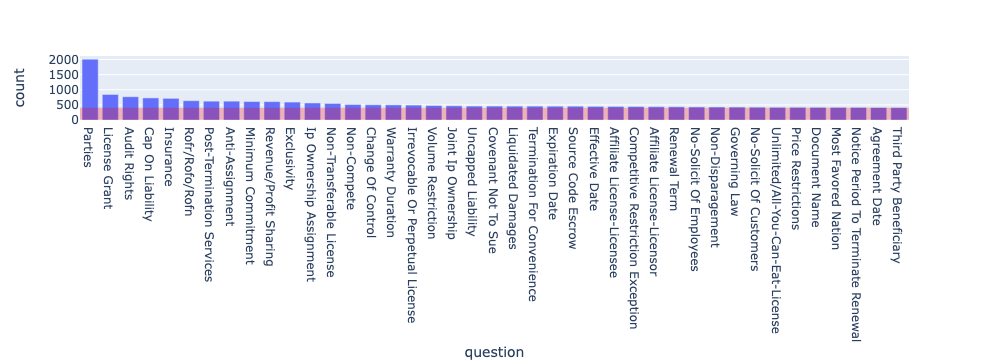

In [46]:
import plotly.express as px

fig = px.bar(df, x='question', y='count')
fig.add_hrect(y0=0, y1=408, line_width=0, fillcolor="red", opacity=0.25)
# save fig
fig.write_image("Figures_For_Report/question_count_bar.png")
fig.show()

### Expanding the dataset

Creating versions of the dataset with the added answers

In [12]:
import json
from copy import deepcopy
import re
from collections import defaultdict
# load json file
with open('../data/train.json') as json_file:
    data = json.load(json_file)

Will make three datasets to run
* All markings
* Removed dates
* Removed dates and parties


### All markings

In [13]:
contract_data = {}
contract_contrast = {}
for contract in data['data']:
    for para in contract['paragraphs']:
        context = para['context']
        for qa in para['qas']:
            question = qa['question']

            if question not in contract_contrast:
                contract_contrast[question] = [0,0]

            answers = qa['answers']
            
            answers_set = set()
            for answer in answers:
                temp = [(m.start(),answer['text']) for m in re.finditer(re.escape(answer['text']), context)]
                for x in temp:
                    answers_set.add(x)
        
            ans2= [{'answer_start': x[0], 'text': x[1]} for x in answers_set]

            contract_contrast[question][0] += len(answers)
            contract_contrast[question][1] += len(ans2)

            contract_data[qa['id']] = {'old':len(answers), 'new': len(ans2), 'answers': ans2}
            qa['answers'] = ans2

In [14]:
import matplotlib.pyplot as plt
import numpy as np

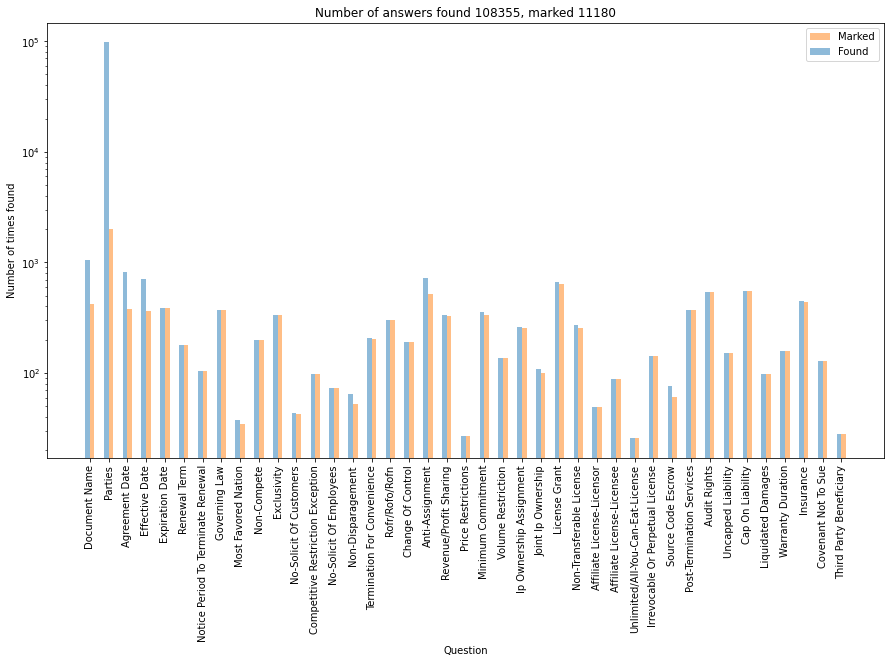

In [15]:
X = contract_contrast.keys()
X_short = [x.split('"')[1] for x in list(X)]
Y_Found = [contract_contrast[x][1] for x in X]
Y_Marked = [contract_contrast[x][0] for x in X]


fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(8)
fig.set_figwidth(15)
ind = np.arange(len(X_short))  # the x locations for the groups
width = 0.25      # the width of the bars

bar_found =ax.bar(ind, Y_Found, align='center', alpha=0.5, width=width)
bar_marked = ax.bar(ind + width , Y_Marked, align='center', alpha=0.5, width=width)
ax.set_ylabel('Number of times found')
ax.set_xlabel('Question')
ax.set_xticks(ind + width / 2, rotation=90)
ax.set_xticklabels( X_short, rotation=90)
plt.yscale("log")  

plt.title(f'Number of answers found {sum(Y_Found)}, marked {sum(Y_Marked)}')
plt.legend( (bar_marked, bar_found), ('Marked','Found') )
plt.show()

In [16]:
# Dump to json
with open('../data/train_extra_ans_all.json', 'w') as outfile:
    json.dump(data, outfile)

### Removed dates


In [21]:
with open('../data/train.json') as json_file:
    data = json.load(json_file)

In [22]:
contract_data = {}
contract_contrast = {}
for contract in data['data']:
    for para in contract['paragraphs']:
        context = para['context']
        for qa in para['qas']:
            question = qa['question']
            
            # Skip date questions
            if "date" in question:
                continue

            if question not in contract_contrast:
                contract_contrast[question] = [0,0]

            answers = qa['answers']
            
            answers_set = set()
            for answer in answers:
                temp = [(m.start(),answer['text']) for m in re.finditer(re.escape(answer['text']), context)]
                for x in temp:
                    answers_set.add(x)
        
            ans2= [{'answer_start': x[0], 'text': x[1]} for x in answers_set]

            contract_contrast[question][0] += len(answers)
            contract_contrast[question][1] += len(ans2)

            contract_data[qa['id']] = {'old':len(answers), 'new': len(ans2), 'answers': ans2}
            qa['answers'] = ans2

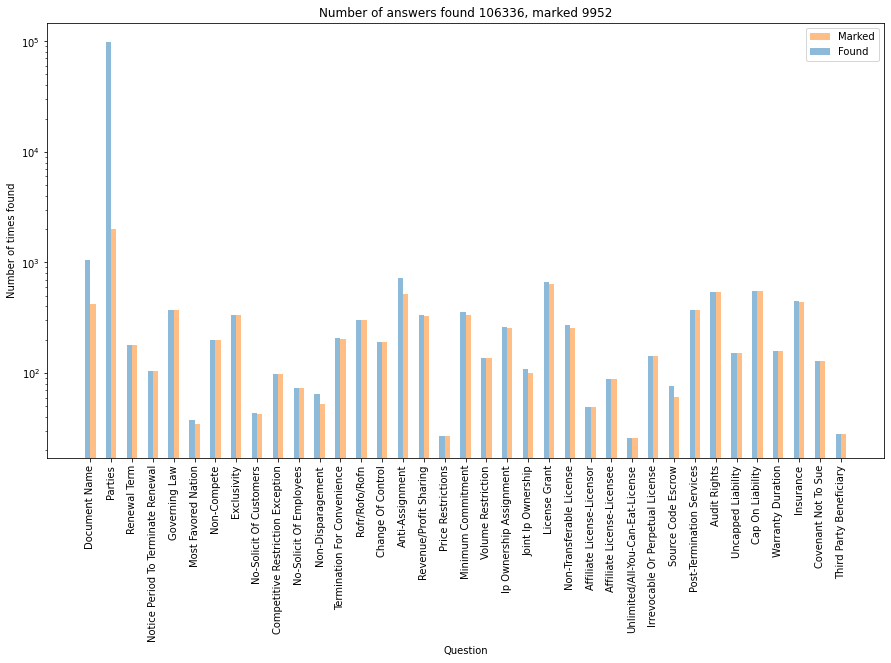

In [23]:
X = contract_contrast.keys()
X_short = [x.split('"')[1] for x in list(X)]
Y_Found = [contract_contrast[x][1] for x in X]
Y_Marked = [contract_contrast[x][0] for x in X]


fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(8)
fig.set_figwidth(15)
ind = np.arange(len(X_short))  # the x locations for the groups
width = 0.25      # the width of the bars

bar_found =ax.bar(ind, Y_Found, align='center', alpha=0.5, width=width)
bar_marked = ax.bar(ind + width , Y_Marked, align='center', alpha=0.5, width=width)
ax.set_ylabel('Number of times found')
ax.set_xlabel('Question')
ax.set_xticks(ind + width / 2, rotation=90)
ax.set_xticklabels( X_short, rotation=90)
plt.yscale("log")  
plt.title(f'Number of answers found {sum(Y_Found)}, marked {sum(Y_Marked)}')
plt.legend( (bar_marked, bar_found), ('Marked','Found') )
plt.show()

In [24]:
# Dump to json
with open('../data/train_extra_ans_no_dates.json', 'w') as outfile:
    json.dump(data, outfile)

### No dates or parties

In [29]:
with open('../data/train.json') as json_file:
    data = json.load(json_file)

In [30]:
contract_data = {}
contract_contrast = {}
for contract in data['data']:
    for para in contract['paragraphs']:
        context = para['context']
        for qa in para['qas']:
            question = qa['question']

            # Skip date  and parties questions
            if ("date" in question) or ("parties" in question):
                continue

            if question not in contract_contrast:
                contract_contrast[question] = [0,0]

            answers = qa['answers']
            
            answers_set = set()
            for answer in answers:
                temp = [(m.start(),answer['text']) for m in re.finditer(re.escape(answer['text']), context)]
                for x in temp:
                    answers_set.add(x)
        
            ans2= [{'answer_start': x[0], 'text': x[1]} for x in answers_set]

            contract_contrast[question][0] += len(answers)
            contract_contrast[question][1] += len(ans2)

            contract_data[qa['id']] = {'old':len(answers), 'new': len(ans2), 'answers': ans2}
            qa['answers'] = ans2

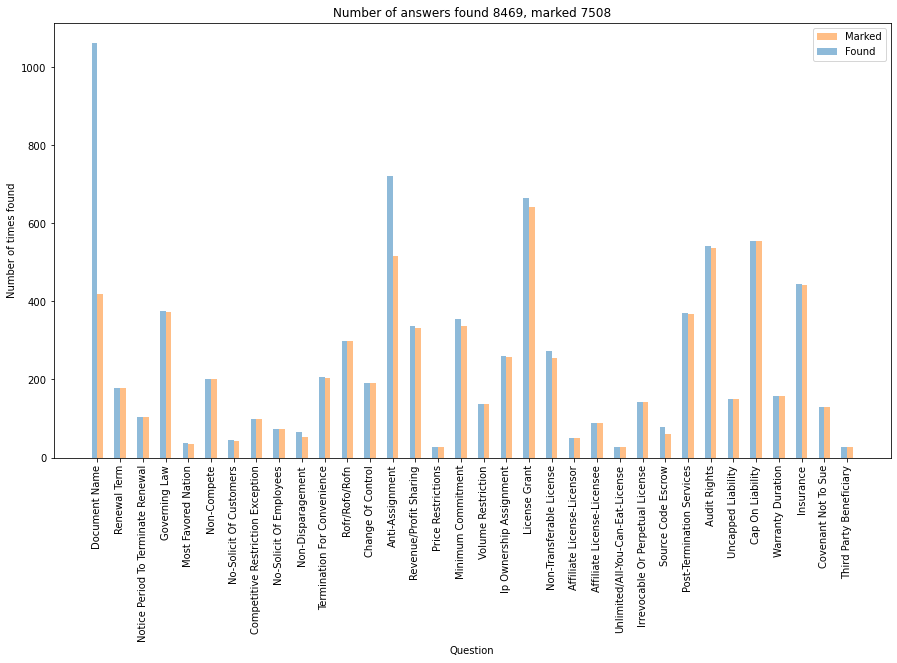

In [32]:
X = contract_contrast.keys()
X_short = [x.split('"')[1] for x in list(X)]
Y_Found = [contract_contrast[x][1] for x in X]
Y_Marked = [contract_contrast[x][0] for x in X]


fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(8)
fig.set_figwidth(15)
ind = np.arange(len(X_short))  # the x locations for the groups
width = 0.25      # the width of the bars

bar_found =ax.bar(ind, Y_Found, align='center', alpha=0.5, width=width)
bar_marked = ax.bar(ind + width , Y_Marked, align='center', alpha=0.5, width=width)
ax.set_ylabel('Number of times found')
ax.set_xlabel('Question')
ax.set_xticks(ind + width / 2, rotation=90)
ax.set_xticklabels( X_short, rotation=90)
plt.title(f'Number of answers found {sum(Y_Found)}, marked {sum(Y_Marked)}')
plt.legend( (bar_marked, bar_found), ('Marked','Found') )
plt.show()

In [33]:
# Dump to json
with open('../data/train_extra_ans_no_dates_or_parties.json', 'w') as outfile:
    json.dump(data, outfile)